# CO2/CH4 retrieved from satellite data vs. ground-based data

+ focus on monthly aggregated $CO_2$, $CH_4$ data
+ satellite data:
    + downloaded from Climate Data Store
    + EMMA algo.
    + years: 2003-present
+ ground-based data:
    + downloaded from esgf
    + project: input4MIPs, era: CMIP6Plus, CMIP7
    + years: 2003-present

In [7]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Function to convert the time format
def reformat_date(date_str):
    return datetime.strptime(date_str, "%Y-%m")

In [8]:
def join_data(gas = "co2"):
    gb_df = pd.read_csv(f"../ground-based-data/datasets/agg_{gas}_2003-present.csv")
    sat_df = pd.read_csv(f"../satellite-data/datasets/merged_emma_{gas}_df.csv")

    # prepare the CO2-satellite data
    lat_values = sat_df.lat.values

    # Create a list of conditions and corresponding values
    conditions = [
        (lat_values > 0, "north"),
        (lat_values < 0, "south")
    ]

    # Use numpy.select for efficient condition checking
    hemisp = np.select([condition[0] for condition in conditions],
                       [condition[1] for condition in conditions],
                       default="undefined")

    sat_df["hemisphere"] = hemisp
    sat_df["year_month"] = sat_df["year"].astype(str)+"-"+sat_df["month"].astype(str)
    sat = sat_df.groupby(["year_month", "year", "month", "hemisphere"]).agg({"values": "mean"}).reset_index()
    sat["method"] = "sat-emma"
    sat = sat.rename(columns={"values":gas})

    # prepare the CO2 ground-based data
    gb = gb_df[["year_month", "values", "version", "year", "month"]]
    gb = gb.rename(columns={"values": gas, "version": "method"})
    gb["hemisphere"] = "unspecified"

    # join data sets
    joined_df = pd.concat([sat, gb], join="outer")
    joined_df["year_month"]=[reformat_date(date) for date in joined_df.year_month.values]
    return joined_df

In [11]:
def plot_monthly_avg(dat, gas):
    fig, ax = plt.subplots(2,1, figsize=(7,5), constrained_layout=True, sharex=True, sharey=True)
    for i, hem in enumerate(["north", "south"]):
        sns.lineplot(x="year_month",y=gas, hue="method",
                     data=dat[dat['hemisphere'].isin([hem, 'unspecified'])],
                     ax=ax[i]
        )
        ax[i].tick_params(axis='x', labelrotation=90)
        ax[i].set_title(f"monthly avg. {gas}; sat. lat.: "+hem)
    plt.show()

In [13]:
joined_co2_df = join_data(gas = "co2")

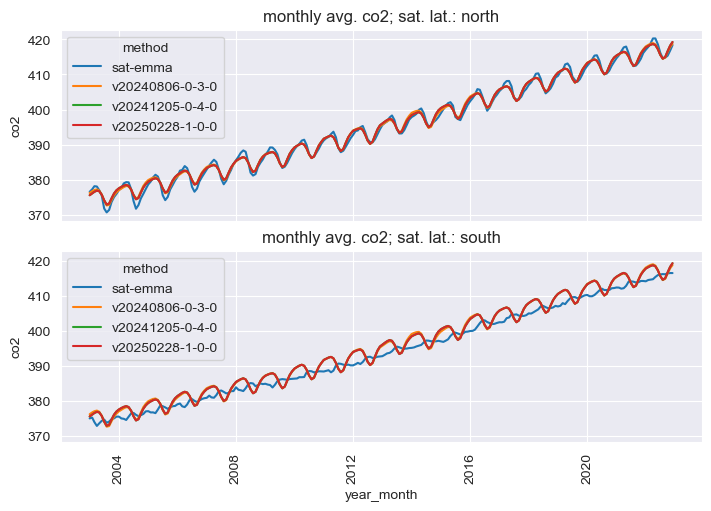

In [14]:
plot_monthly_avg(joined_co2_df, "co2")

In [15]:
joined_ch4_df = join_data(gas = "ch4")

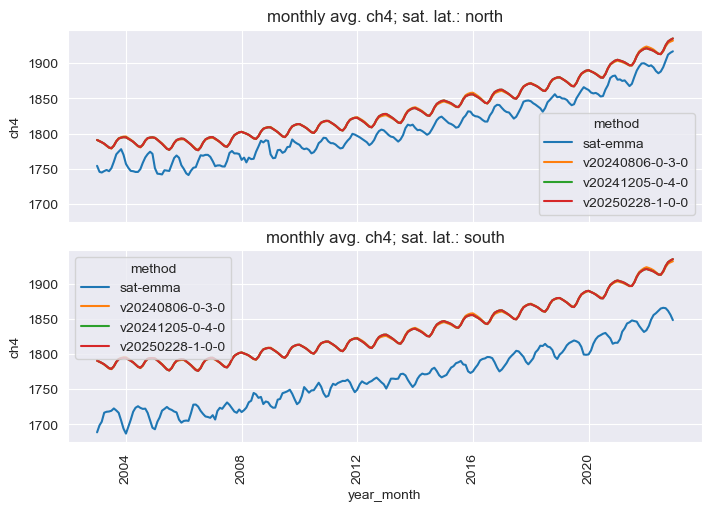

In [16]:
plot_monthly_avg(joined_ch4_df, "ch4")